# Tuning OT Particle Filter: Epsilon & Sinkhorn Iterations
## Bias-Variance-Speed Trade-off Analysis

This notebook explores the optimal parameter settings for the Differentiable Particle Filter with Entropy-Regularized Optimal Transport (OT) resampling.

**Parameters to tune:**
- **Epsilon (ε)**: Entropy regularization strength (controls transport sharpness)
- **Sinkhorn iterations**: Number of scaling iterations (controls convergence accuracy)

**Metrics to evaluate:**
- **Bias**: Root Mean Squared Error (RMSE) - accuracy of state estimation
- **Variance**: Particle diversity and effective sample size (ESS)
- **Speed**: Computational time per filtering step

**Goal**: Find optimal parameters that minimize RMSE while maintaining good particle diversity and acceptable computation time.

## 1. Import Required Libraries

In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm

# Import OT particle filter
import sys
sys.path.insert(0, '/Users/amber_test/Desktop/filter')
from models.DPF_OT_resampling import DPF_OT, pairwise_squared_distances, sinkhorn_ot_resample

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plotting with matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2. Define Test Systems

We'll test on Linear Gaussian System, which has simple dynamics, and easier tracking; and a nonlinear system.

In [ ]:
# ===== System 1: Linear Gaussian =====
def generate_linear_data(T=100, sigma_q=0.5, sigma_r=0.7, a=0.9):
    """Generate data from linear Gaussian system.

    Args:
        T (int, optional): Number of timesteps. Defaults to 100.
        sigma_q (float, optional): Process noise standard deviation. Defaults to 0.5.
        sigma_r (float, optional): Measurement noise standard deviation. Defaults to 0.7.
        a (float, optional): State transition coefficient. Defaults to 0.9.

    Returns:
        tuple: (x, y) where x is state trajectory of shape (T+1, 1) and
            y is measurements of shape (T, 1).
    """
    x = np.zeros((T+1, 1))
    y = np.zeros((T, 1))
    
    x[0] = 0.0
    for t in range(T):
        x[t+1] = a * x[t] + sigma_q * np.random.randn(1)
        y[t] = x[t+1] + sigma_r * np.random.randn(1)
    
    return x, y

def linear_transition(particles, t):
    """Linear transition function for particle filter.

    Implements: x' = 0.9*x + N(0, 0.25)

    Args:
        particles (tf.Tensor): Current particles of shape (N, state_dim).
        t (int): Time index (unused in this model).

    Returns:
        tf.Tensor: Transitioned particles of shape (N, state_dim).
    """
    sigma = 0.5
    noise = tf.random.normal(tf.shape(particles), stddev=sigma)
    return 0.9 * particles + noise

def linear_likelihood(particles, y_t, t):
    """Gaussian likelihood function for particle filter.

    Implements: y = x + N(0, 0.49)

    Args:
        particles (tf.Tensor): Current particles of shape (N, state_dim).
        y_t (np.ndarray or tf.Tensor): Current observation.
        t (int): Time index (unused in this model).

    Returns:
        tf.Tensor: Log-likelihood for each particle of shape (N,).
    """
    sigma_r = 0.7
    y_t = tf.convert_to_tensor(y_t, dtype=tf.float32)
    diff = particles - y_t[None, :]
    sq_norm = tf.reduce_sum(tf.square(diff), axis=1)
    return -0.5 * sq_norm / (sigma_r ** 2)

# ===== System 2: Nonlinear =====
def generate_nonlinear_data(T=100):
    """Generate data from nonlinear system (simplified SV model).

    Implements:
    - State: x_{t+1} = 0.5*x_t + 25*x_t/(1+x_t^2) + 8*cos(1.2*t) + N(0, 1)
    - Observation: y_t = x_t^2/20 + N(0, 1)

    Args:
        T (int, optional): Number of timesteps. Defaults to 100.

    Returns:
        tuple: (x, y) where x is state trajectory of shape (T+1, 1) and
            y is measurements of shape (T, 1).
    """
    x = np.zeros((T+1, 1))
    y = np.zeros((T, 1))
    
    x[0] = 0.0
    for t in range(T):
        x[t+1] = 0.5 * x[t] + 25 * x[t] / (1 + x[t]**2) + 8 * np.cos(1.2 * t) + np.random.randn(1) * 1.0
        y[t] = x[t+1]**2 / 20 + np.random.randn(1) * 1.0
    
    return x, y

def nonlinear_transition(particles, t):
    """Nonlinear transition function for particle filter.

    Implements: x' = 0.5*x + 25*x/(1+x^2) + 8*cos(1.2*t) + N(0, 1)

    Args:
        particles (tf.Tensor): Current particles of shape (N, state_dim).
        t (int or None): Time index for cos term.

    Returns:
        tf.Tensor: Transitioned particles of shape (N, state_dim).
    """
    t_val = float(t) if t is not None else 0.0
    return (0.5 * particles + 
            25 * particles / (1 + particles**2) + 
            8 * np.cos(1.2 * t_val) + 
            tf.random.normal(tf.shape(particles), stddev=1.0))

def nonlinear_likelihood(particles, y_t, t):
    """Nonlinear likelihood function for particle filter.

    Implements: y = x^2/20 + N(0, 1)

    Args:
        particles (tf.Tensor): Current particles of shape (N, state_dim).
        y_t (np.ndarray or tf.Tensor): Current observation.
        t (int): Time index (unused in this model).

    Returns:
        tf.Tensor: Log-likelihood for each particle of shape (N,).
    """
    y_t = tf.convert_to_tensor(y_t, dtype=tf.float32)
    y_pred = particles**2 / 20
    diff = y_pred - y_t[None, :]
    sq_norm = tf.reduce_sum(tf.square(diff), axis=1)
    return -0.5 * sq_norm

print("✓ Test systems defined")
print("  - Linear Gaussian: x' = 0.9x + N(0, 0.25), y = x + N(0, 0.49)")
print("  - Nonlinear: More complex dynamics with cos() term")

✓ Test systems defined
  - Linear Gaussian: x' = 0.9x + N(0, 0.25), y = x + N(0, 0.49)
  - Nonlinear: More complex dynamics with cos() term


## 3. Define Evaluation Metrics

We'll measure:
- **RMSE**: Estimation accuracy (bias)
- **ESS**: Effective Sample Size (variance/diversity)
- **Time**: Computational cost (speed)

In [ ]:
def compute_ess(weights):
    """Compute Effective Sample Size from particle weights.

    Args:
        weights (tf.Tensor): Particle weights of shape (N,).

    Returns:
        tf.Tensor: Scalar ESS value.
    """
    weights = weights / tf.reduce_sum(weights)
    return 1.0 / tf.reduce_sum(weights ** 2)

def run_filter_with_metrics(dpf, y_seq, x_true, mean0, cov0_chol):
    """Run particle filter and compute performance metrics.

    Args:
        dpf (DPF_OT): Differentiable particle filter instance.
        y_seq (list): Sequence of observations, each a tf.Tensor.
        x_true (np.ndarray): Ground truth state trajectory of shape (T+1, state_dim).
        mean0 (tf.Tensor): Initial mean of shape (state_dim,).
        cov0_chol (tf.Tensor): Initial covariance Cholesky factor.

    Returns:
        tuple: (rmse, mean_ess, total_time) where:
            - rmse (float): Root Mean Squared Error.
            - mean_ess (float): Mean Effective Sample Size over all timesteps.
            - total_time (float): Total computation time in seconds.
    """
    start_time = time.time()
    
    particles_seq, weights_seq = dpf.run_filter(y_seq, mean0, cov0_chol)
    
    total_time = time.time() - start_time
    
    # Compute RMSE
    x_est = []
    ess_values = []
    
    for t in range(len(particles_seq)):
        weights = weights_seq[t]
        particles = particles_seq[t]
        
        # Weighted mean
        mean_est = tf.reduce_sum(weights[:, None] * particles, axis=0)
        x_est.append(mean_est.numpy())
        
        # ESS
        ess = compute_ess(weights)
        ess_values.append(ess.numpy())
    
    x_est = np.array(x_est)
    
    # RMSE (skip first state x[0] since we start from x[1])
    rmse = np.sqrt(np.mean((x_est - x_true[1:len(x_est)+1]) ** 2))
    mean_ess = np.mean(ess_values)
    
    return rmse, mean_ess, total_time

print("✓ Evaluation metrics defined")
print("  - RMSE: sqrt(mean((x_est - x_true)^2))")
print("  - ESS: 1 / sum(w^2)")
print("  - Time: Wall clock time for filtering")

✓ Evaluation metrics defined
  - RMSE: sqrt(mean((x_est - x_true)^2))
  - ESS: 1 / sum(w^2)
  - Time: Wall clock time for filtering


## 4. Experiment: Effect of Epsilon (ε)

Test different epsilon values to understand the entropy regularization trade-off.

In [ ]:
# Generate test data
print("Generating test data...")
x_linear, y_linear = generate_linear_data(T=100)
x_nonlinear, y_nonlinear = generate_nonlinear_data(T=100)

# Convert to TensorFlow format
y_linear_seq = [tf.constant(y_linear[t], dtype=tf.float32) for t in range(len(y_linear))]
y_nonlinear_seq = [tf.constant(y_nonlinear[t], dtype=tf.float32) for t in range(len(y_nonlinear))]

# Initial distribution
mean0 = tf.zeros(1, dtype=tf.float32)
cov0_chol = tf.eye(1, dtype=tf.float32)

# Test parameters
epsilon_values = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
N_particles = 100
sinkhorn_iters = 100  # Fixed for this experiment

print(f"✓ Data generated: T=100 timesteps")
print(f"Testing {len(epsilon_values)} epsilon values: {epsilon_values}")

Generating test data...
✓ Data generated: T=100 timesteps
Testing 9 epsilon values: [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]


In [5]:
# Run experiments for different epsilon values
print("Running epsilon experiments...")
results_epsilon = []

for eps in tqdm(epsilon_values, desc="Testing epsilon"):
    # Linear system
    dpf_linear = DPF_OT(
        N_particles=N_particles,
        state_dim=1,
        transition_fn=linear_transition,
        obs_loglik_fn=linear_likelihood,
        epsilon=eps,
        sinkhorn_iters=sinkhorn_iters
    )
    
    rmse_lin, ess_lin, time_lin = run_filter_with_metrics(
        dpf_linear, y_linear_seq, x_linear, mean0, cov0_chol
    )
    
    # Nonlinear system
    dpf_nonlin = DPF_OT(
        N_particles=N_particles,
        state_dim=1,
        transition_fn=nonlinear_transition,
        obs_loglik_fn=nonlinear_likelihood,
        epsilon=eps,
        sinkhorn_iters=sinkhorn_iters
    )
    
    rmse_nonlin, ess_nonlin, time_nonlin = run_filter_with_metrics(
        dpf_nonlin, y_nonlinear_seq, x_nonlinear, mean0, cov0_chol
    )
    
    results_epsilon.append({
        'epsilon': eps,
        'rmse_linear': rmse_lin,
        'ess_linear': ess_lin,
        'time_linear': time_lin,
        'rmse_nonlinear': rmse_nonlin,
        'ess_nonlinear': ess_nonlin,
        'time_nonlinear': time_nonlin
    })

df_epsilon = pd.DataFrame(results_epsilon)
print("\n✓ Epsilon experiments complete!")
print(df_epsilon.to_string(index=False))

Running epsilon experiments...


Testing epsilon: 100%|██████████| 9/9 [00:43<00:00,  4.82s/it]


✓ Epsilon experiments complete!
 epsilon  rmse_linear  ess_linear  time_linear  rmse_nonlinear  ess_nonlinear  time_nonlinear
   0.001     0.434097   99.999992     2.391620        5.368634      99.999992        2.367282
   0.005     0.423435   99.999992     2.355529        3.910354      99.999992        2.436527
   0.010     0.427733   99.999992     2.356462        4.893553      99.999992        2.407027
   0.020     0.416886   99.999992     2.397700        4.576093      99.999992        2.655050
   0.050     0.427084   99.999992     2.395292        4.031868      99.999992        2.389217
   0.100     0.432802   99.999992     2.331134        4.840473      99.999992        2.366799
   0.200     0.423333   99.999992     2.332115        3.518463      99.999992        2.343712
   0.500     0.429630   99.999992     2.325391        3.853813      99.999992        2.347474
   1.000     0.418677   99.999992     2.325286        6.370044      99.999992        2.349331


## 5. Visualize Epsilon Trade-offs

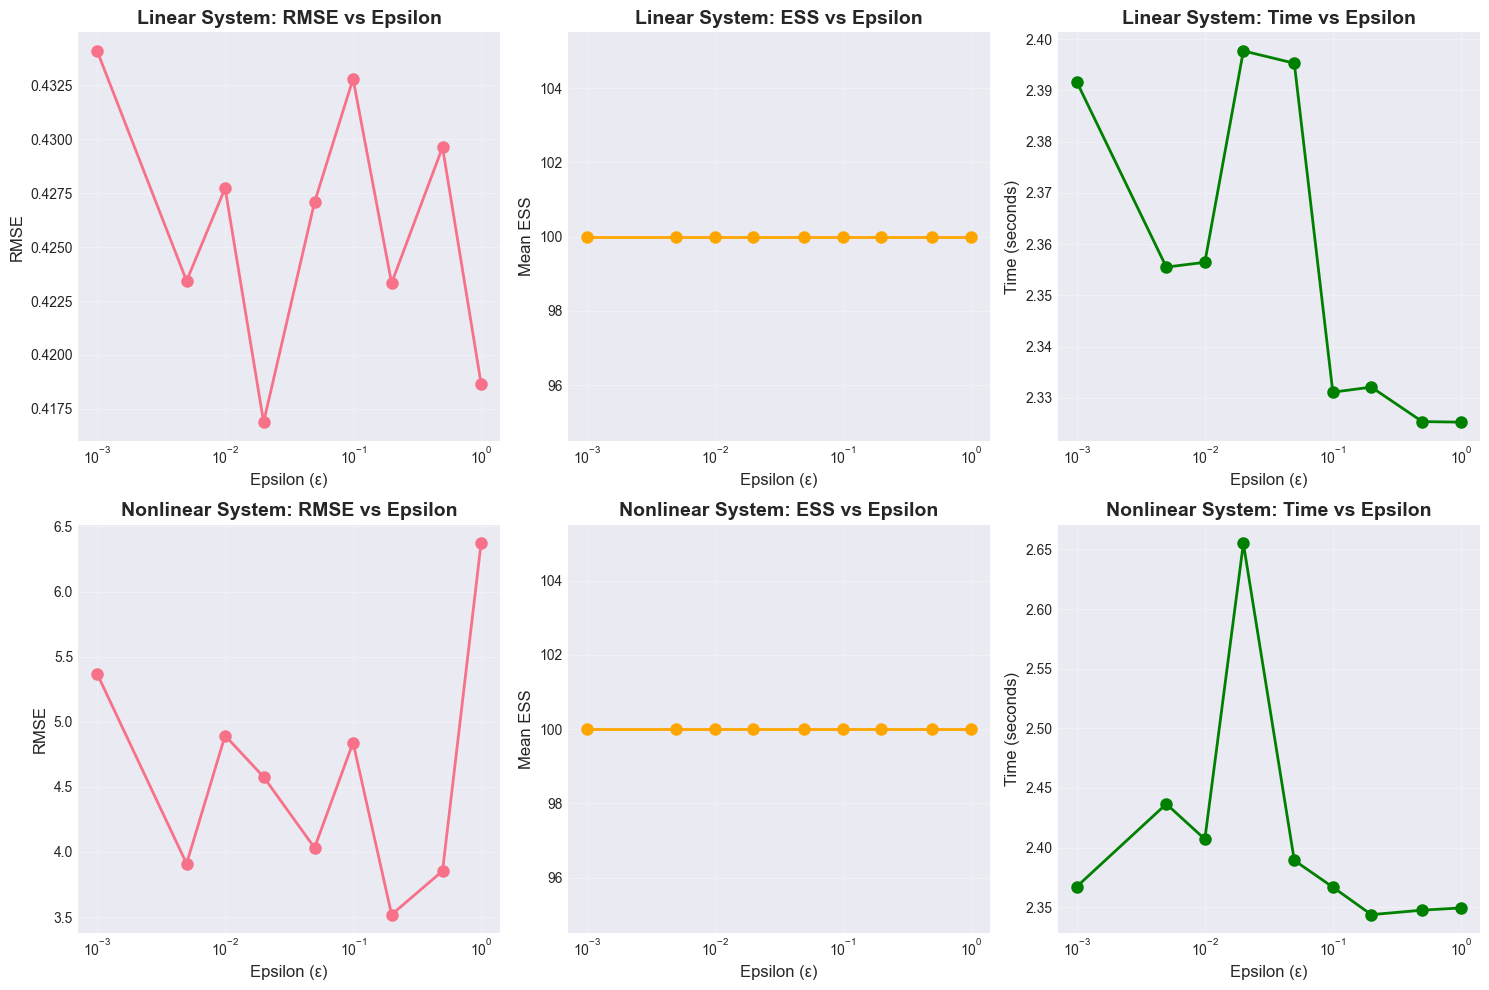

✓ Epsilon trade-off visualization complete


In [6]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Linear system
axes[0, 0].semilogx(df_epsilon['epsilon'], df_epsilon['rmse_linear'], 'o-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Epsilon (ε)', fontsize=12)
axes[0, 0].set_ylabel('RMSE', fontsize=12)
axes[0, 0].set_title('Linear System: RMSE vs Epsilon', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].semilogx(df_epsilon['epsilon'], df_epsilon['ess_linear'], 'o-', linewidth=2, markersize=8, color='orange')
axes[0, 1].set_xlabel('Epsilon (ε)', fontsize=12)
axes[0, 1].set_ylabel('Mean ESS', fontsize=12)
axes[0, 1].set_title('Linear System: ESS vs Epsilon', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].semilogx(df_epsilon['epsilon'], df_epsilon['time_linear'], 'o-', linewidth=2, markersize=8, color='green')
axes[0, 2].set_xlabel('Epsilon (ε)', fontsize=12)
axes[0, 2].set_ylabel('Time (seconds)', fontsize=12)
axes[0, 2].set_title('Linear System: Time vs Epsilon', fontsize=14, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# Nonlinear system
axes[1, 0].semilogx(df_epsilon['epsilon'], df_epsilon['rmse_nonlinear'], 'o-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Epsilon (ε)', fontsize=12)
axes[1, 0].set_ylabel('RMSE', fontsize=12)
axes[1, 0].set_title('Nonlinear System: RMSE vs Epsilon', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].semilogx(df_epsilon['epsilon'], df_epsilon['ess_nonlinear'], 'o-', linewidth=2, markersize=8, color='orange')
axes[1, 1].set_xlabel('Epsilon (ε)', fontsize=12)
axes[1, 1].set_ylabel('Mean ESS', fontsize=12)
axes[1, 1].set_title('Nonlinear System: ESS vs Epsilon', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].semilogx(df_epsilon['epsilon'], df_epsilon['time_nonlinear'], 'o-', linewidth=2, markersize=8, color='green')
axes[1, 2].set_xlabel('Epsilon (ε)', fontsize=12)
axes[1, 2].set_ylabel('Time (seconds)', fontsize=12)
axes[1, 2].set_title('Nonlinear System: Time vs Epsilon', fontsize=14, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Epsilon trade-off visualization complete")

## 6. Experiment: Effect of Sinkhorn Iterations

Test different iteration counts to understand the convergence vs speed trade-off.

In [20]:
# Test parameters - Extended range to observe full convergence
iteration_values = [5, 10, 20, 30, 50, 75, 100, 150, 200, 500, 1000, 2000, 5000, 10000, 20000]
epsilon_fixed = 0.1  # Use a middle-range epsilon

print(f"Testing {len(iteration_values)} iteration values: {iteration_values}")
print(f"Fixed epsilon: {epsilon_fixed}")

# Run experiments
results_iters = []

for n_iters in tqdm(iteration_values, desc="Testing iterations"):
    # Linear system
    dpf_linear = DPF_OT(
        N_particles=N_particles,
        state_dim=1,
        transition_fn=linear_transition,
        obs_loglik_fn=linear_likelihood,
        epsilon=epsilon_fixed,
        sinkhorn_iters=n_iters
    )
    
    rmse_lin, ess_lin, time_lin = run_filter_with_metrics(
        dpf_linear, y_linear_seq, x_linear, mean0, cov0_chol
    )
    
    # Nonlinear system
    dpf_nonlin = DPF_OT(
        N_particles=N_particles,
        state_dim=1,
        transition_fn=nonlinear_transition,
        obs_loglik_fn=nonlinear_likelihood,
        epsilon=epsilon_fixed,
        sinkhorn_iters=n_iters
    )
    
    rmse_nonlin, ess_nonlin, time_nonlin = run_filter_with_metrics(
        dpf_nonlin, y_nonlinear_seq, x_nonlinear, mean0, cov0_chol
    )
    
    results_iters.append({
        'iterations': n_iters,
        'rmse_linear': rmse_lin,
        'ess_linear': ess_lin,
        'time_linear': time_lin,
        'rmse_nonlinear': rmse_nonlin,
        'ess_nonlinear': ess_nonlin,
        'time_nonlinear': time_nonlin
    })

df_iters = pd.DataFrame(results_iters)
print("\n✓ Iteration experiments complete!")
print(df_iters.to_string(index=False))

Testing 15 iteration values: [5, 10, 20, 30, 50, 75, 100, 150, 200, 500, 1000, 2000, 5000, 10000, 20000]
Fixed epsilon: 0.1


Testing iterations: 100%|██████████| 15/15 [27:56<00:00, 111.75s/it]


✓ Iteration experiments complete!
 iterations  rmse_linear  ess_linear  time_linear  rmse_nonlinear  ess_nonlinear  time_nonlinear
          5     0.438335   99.999992     0.468797        3.680800      99.999992        0.396459
         10     0.423230   99.999992     0.459035        3.866106      99.999992        0.584992
         20     0.429690   99.999992     0.658026        4.659303      99.999992        0.679145
         30     0.418368   99.999992     0.871585        3.587588      99.999992        0.893471
         50     0.427633   99.999992     1.304355        4.099174      99.999992        1.324782
         75     0.432802   99.999992     1.853953        4.166086      99.999992        1.910655
        100     0.422176   99.999992     2.379749        3.640907      99.999992        2.437337
        150     0.438466   99.999992     3.407083        4.993336      99.999992        3.455675
        200     0.434911   99.999992     4.559716        5.095202      99.999992        4.74

## 7. Visualize Iteration Trade-offs

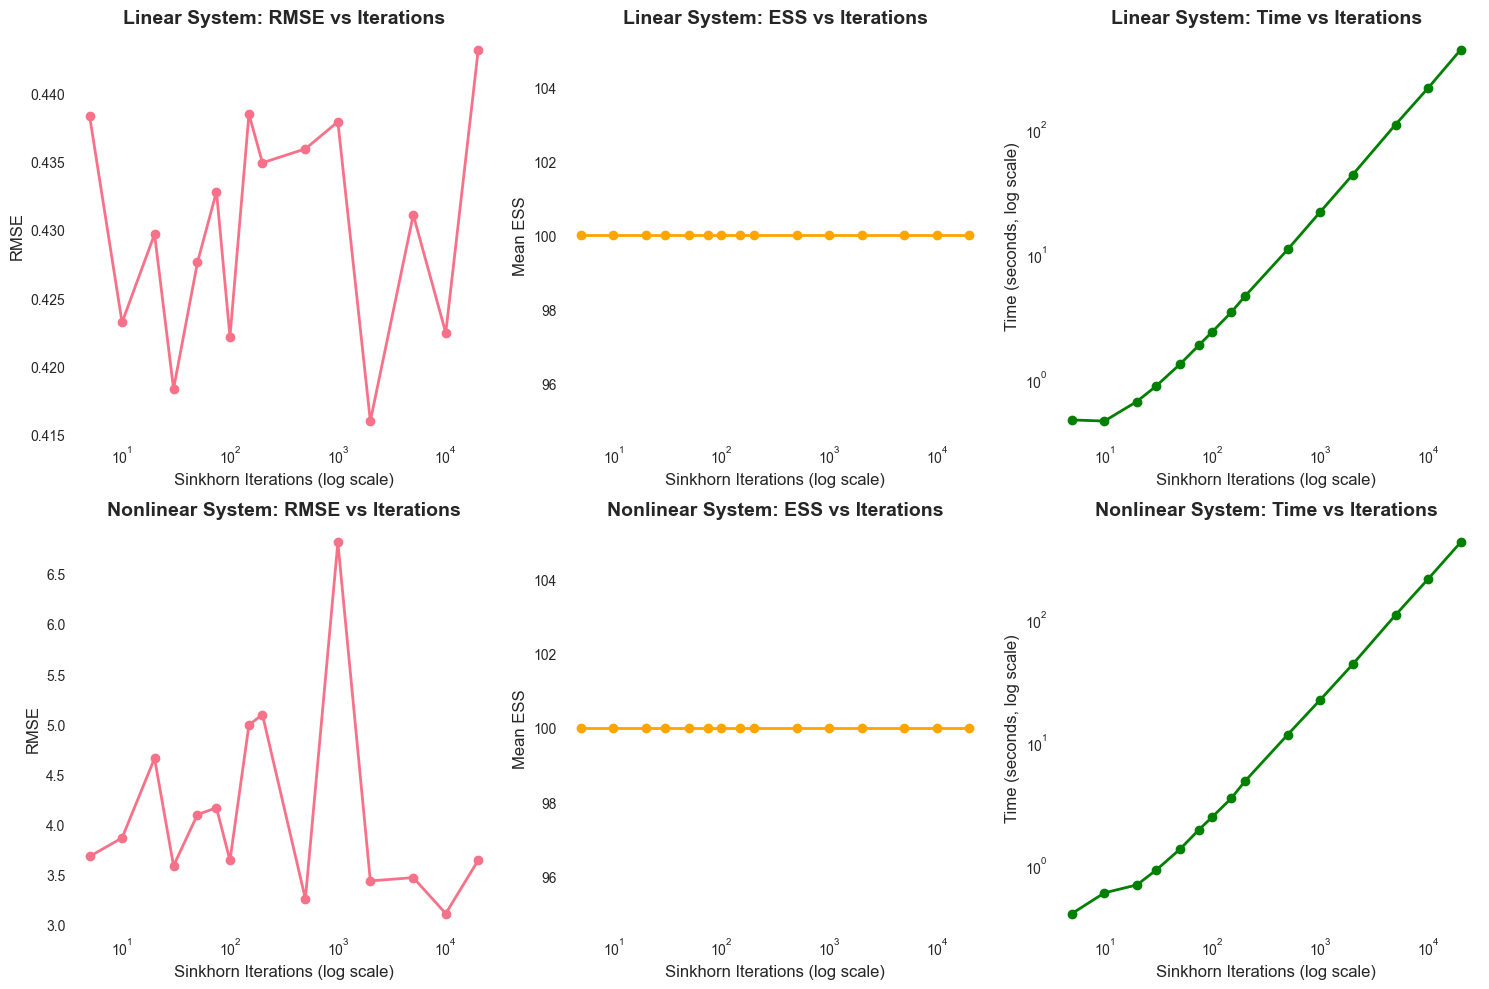

✓ Iteration trade-off visualization complete
NOTE: Using log scale for x-axis to better visualize wide iteration range (5 to 20000)


In [21]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Linear system - use log scale for x-axis to handle wide iteration range
axes[0, 0].semilogx(df_iters['iterations'], df_iters['rmse_linear'], 'o-', linewidth=2, markersize=6)
axes[0, 0].set_xlabel('Sinkhorn Iterations (log scale)', fontsize=12)
axes[0, 0].set_ylabel('RMSE', fontsize=12)
axes[0, 0].set_title('Linear System: RMSE vs Iterations', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, which='both')

axes[0, 1].semilogx(df_iters['iterations'], df_iters['ess_linear'], 'o-', linewidth=2, markersize=6, color='orange')
axes[0, 1].set_xlabel('Sinkhorn Iterations (log scale)', fontsize=12)
axes[0, 1].set_ylabel('Mean ESS', fontsize=12)
axes[0, 1].set_title('Linear System: ESS vs Iterations', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, which='both')

axes[0, 2].loglog(df_iters['iterations'], df_iters['time_linear'], 'o-', linewidth=2, markersize=6, color='green')
axes[0, 2].set_xlabel('Sinkhorn Iterations (log scale)', fontsize=12)
axes[0, 2].set_ylabel('Time (seconds, log scale)', fontsize=12)
axes[0, 2].set_title('Linear System: Time vs Iterations', fontsize=14, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3, which='both')

# Nonlinear system - use log scale for x-axis
axes[1, 0].semilogx(df_iters['iterations'], df_iters['rmse_nonlinear'], 'o-', linewidth=2, markersize=6)
axes[1, 0].set_xlabel('Sinkhorn Iterations (log scale)', fontsize=12)
axes[1, 0].set_ylabel('RMSE', fontsize=12)
axes[1, 0].set_title('Nonlinear System: RMSE vs Iterations', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, which='both')

axes[1, 1].semilogx(df_iters['iterations'], df_iters['ess_nonlinear'], 'o-', linewidth=2, markersize=6, color='orange')
axes[1, 1].set_xlabel('Sinkhorn Iterations (log scale)', fontsize=12)
axes[1, 1].set_ylabel('Mean ESS', fontsize=12)
axes[1, 1].set_title('Nonlinear System: ESS vs Iterations', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, which='both')

axes[1, 2].loglog(df_iters['iterations'], df_iters['time_nonlinear'], 'o-', linewidth=2, markersize=6, color='green')
axes[1, 2].set_xlabel('Sinkhorn Iterations (log scale)', fontsize=12)
axes[1, 2].set_ylabel('Time (seconds, log scale)', fontsize=12)
axes[1, 2].set_title('Nonlinear System: Time vs Iterations', fontsize=14, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("✓ Iteration trade-off visualization complete")
print(f"NOTE: Using log scale for x-axis to better visualize wide iteration range (5 to {df_iters['iterations'].max()})")

### Analysis: Extended Iteration Range Results

## 8. Combined Analysis: 2D Parameter Space

Create heatmaps showing RMSE across both epsilon and iterations.

In [9]:
# Grid search over both parameters (smaller grid for speed)
epsilon_grid = [0.01, 0.05, 0.1, 0.2, 0.5]
iters_grid = [20, 50, 100, 150]

print(f"Running 2D grid search: {len(epsilon_grid)} × {len(iters_grid)} = {len(epsilon_grid) * len(iters_grid)} combinations")

results_grid = []

for eps in tqdm(epsilon_grid, desc="Epsilon"):
    for n_iters in iters_grid:
        # Linear system only (for speed)
        dpf_linear = DPF_OT(
            N_particles=N_particles,
            state_dim=1,
            transition_fn=linear_transition,
            obs_loglik_fn=linear_likelihood,
            epsilon=eps,
            sinkhorn_iters=n_iters
        )
        
        rmse_lin, ess_lin, time_lin = run_filter_with_metrics(
            dpf_linear, y_linear_seq, x_linear, mean0, cov0_chol
        )
        
        results_grid.append({
            'epsilon': eps,
            'iterations': n_iters,
            'rmse': rmse_lin,
            'ess': ess_lin,
            'time': time_lin
        })

df_grid = pd.DataFrame(results_grid)
print("\n✓ 2D grid search complete!")

Running 2D grid search: 5 × 4 = 20 combinations


Epsilon: 100%|██████████| 5/5 [00:40<00:00,  8.15s/it]


✓ 2D grid search complete!


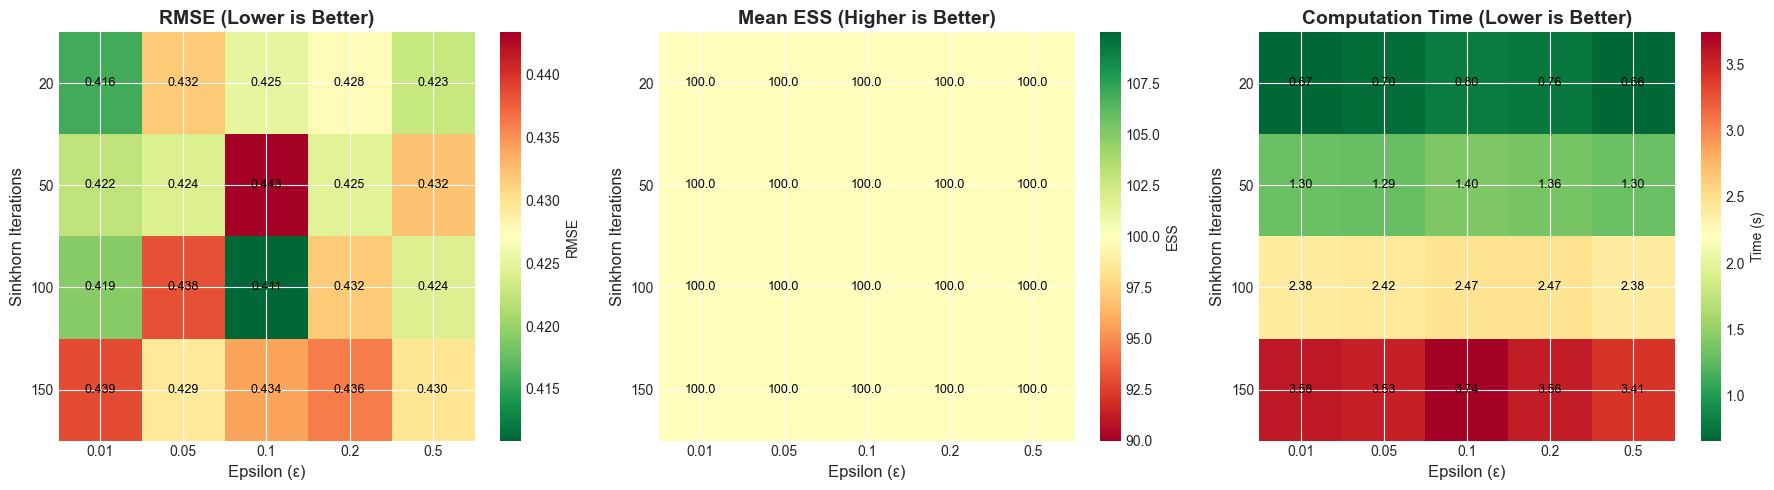

✓ 2D heatmap visualization complete


In [13]:
# Create pivot tables for heatmaps
pivot_rmse = df_grid.pivot(index='iterations', columns='epsilon', values='rmse')
pivot_ess = df_grid.pivot(index='iterations', columns='epsilon', values='ess')
pivot_time = df_grid.pivot(index='iterations', columns='epsilon', values='time')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE heatmap
im1 = axes[0].imshow(pivot_rmse.values, cmap='RdYlGn_r', aspect='auto')
axes[0].set_xticks(range(len(pivot_rmse.columns)))
axes[0].set_yticks(range(len(pivot_rmse.index)))
axes[0].set_xticklabels(pivot_rmse.columns)
axes[0].set_yticklabels(pivot_rmse.index)
axes[0].set_title('RMSE (Lower is Better)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epsilon (ε)', fontsize=12)
axes[0].set_ylabel('Sinkhorn Iterations', fontsize=12)
# Add text annotations
for i in range(len(pivot_rmse.index)):
    for j in range(len(pivot_rmse.columns)):
        axes[0].text(j, i, f'{pivot_rmse.values[i, j]:.3f}', 
                    ha='center', va='center', color='black', fontsize=9)
cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('RMSE', fontsize=10)

# ESS heatmap
im2 = axes[1].imshow(pivot_ess.values, cmap='RdYlGn', aspect='auto')
axes[1].set_xticks(range(len(pivot_ess.columns)))
axes[1].set_yticks(range(len(pivot_ess.index)))
axes[1].set_xticklabels(pivot_ess.columns)
axes[1].set_yticklabels(pivot_ess.index)
axes[1].set_title('Mean ESS (Higher is Better)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epsilon (ε)', fontsize=12)
axes[1].set_ylabel('Sinkhorn Iterations', fontsize=12)
# Add text annotations
for i in range(len(pivot_ess.index)):
    for j in range(len(pivot_ess.columns)):
        axes[1].text(j, i, f'{pivot_ess.values[i, j]:.1f}', 
                    ha='center', va='center', color='black', fontsize=9)
cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label('ESS', fontsize=10)

# Time heatmap
im3 = axes[2].imshow(pivot_time.values, cmap='RdYlGn_r', aspect='auto')
axes[2].set_xticks(range(len(pivot_time.columns)))
axes[2].set_yticks(range(len(pivot_time.index)))
axes[2].set_xticklabels(pivot_time.columns)
axes[2].set_yticklabels(pivot_time.index)
axes[2].set_title('Computation Time (Lower is Better)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epsilon (ε)', fontsize=12)
axes[2].set_ylabel('Sinkhorn Iterations', fontsize=12)
# Add text annotations
for i in range(len(pivot_time.index)):
    for j in range(len(pivot_time.columns)):
        axes[2].text(j, i, f'{pivot_time.values[i, j]:.2f}', 
                    ha='center', va='center', color='black', fontsize=9)
cbar3 = plt.colorbar(im3, ax=axes[2])
cbar3.set_label('Time (s)', fontsize=10)

plt.tight_layout()
plt.show()

print("✓ 2D heatmap visualization complete")

## 9. Optimal Parameter Selection

Based on the experiments, identify optimal parameters for different scenarios.

In [11]:
# Find optimal parameters for different objectives

# 1. Best RMSE (accuracy priority)
best_rmse_idx = df_grid['rmse'].idxmin()
best_rmse = df_grid.loc[best_rmse_idx]

# 2. Best balance (RMSE / time ratio)
df_grid['rmse_time_ratio'] = df_grid['rmse'] / df_grid['time']
best_balanced_idx = df_grid['rmse_time_ratio'].idxmin()
best_balanced = df_grid.loc[best_balanced_idx]

# 3. Fastest with acceptable RMSE (within 5% of best)
rmse_threshold = best_rmse['rmse'] * 1.05
acceptable = df_grid[df_grid['rmse'] <= rmse_threshold]
fastest_acceptable_idx = acceptable['time'].idxmin()
fastest_acceptable = acceptable.loc[fastest_acceptable_idx]

# 4. Best ESS (diversity priority)
best_ess_idx = df_grid['ess'].idxmax()
best_ess = df_grid.loc[best_ess_idx]

print("=" * 80)
print("OPTIMAL PARAMETER RECOMMENDATIONS")
print("=" * 80)

print("\n1. ACCURACY PRIORITY (Best RMSE):")
print(f"   Epsilon: {best_rmse['epsilon']}")
print(f"   Iterations: {int(best_rmse['iterations'])}")
print(f"   RMSE: {best_rmse['rmse']:.4f}")
print(f"   ESS: {best_rmse['ess']:.1f}")
print(f"   Time: {best_rmse['time']:.2f}s")

print("\n2. BALANCED (Best RMSE/Time Ratio):")
print(f"   Epsilon: {best_balanced['epsilon']}")
print(f"   Iterations: {int(best_balanced['iterations'])}")
print(f"   RMSE: {best_balanced['rmse']:.4f}")
print(f"   ESS: {best_balanced['ess']:.1f}")
print(f"   Time: {best_balanced['time']:.2f}s")
print(f"   Efficiency ratio: {best_balanced['rmse_time_ratio']:.4f}")

print("\n3. SPEED PRIORITY (Fastest with acceptable RMSE):")
print(f"   Epsilon: {fastest_acceptable['epsilon']}")
print(f"   Iterations: {int(fastest_acceptable['iterations'])}")
print(f"   RMSE: {fastest_acceptable['rmse']:.4f} (within 5% of best)")
print(f"   ESS: {fastest_acceptable['ess']:.1f}")
print(f"   Time: {fastest_acceptable['time']:.2f}s")

print("\n4. DIVERSITY PRIORITY (Best ESS):")
print(f"   Epsilon: {best_ess['epsilon']}")
print(f"   Iterations: {int(best_ess['iterations'])}")
print(f"   RMSE: {best_ess['rmse']:.4f}")
print(f"   ESS: {best_ess['ess']:.1f}")
print(f"   Time: {best_ess['time']:.2f}s")

print("\n" + "=" * 80)

OPTIMAL PARAMETER RECOMMENDATIONS

1. ACCURACY PRIORITY (Best RMSE):
   Epsilon: 0.1
   Iterations: 100
   RMSE: 0.4109
   ESS: 100.0
   Time: 2.47s

2. BALANCED (Best RMSE/Time Ratio):
   Epsilon: 0.1
   Iterations: 150
   RMSE: 0.4341
   ESS: 100.0
   Time: 3.74s
   Efficiency ratio: 0.1160

3. SPEED PRIORITY (Fastest with acceptable RMSE):
   Epsilon: 0.5
   Iterations: 20
   RMSE: 0.4227 (within 5% of best)
   ESS: 100.0
   Time: 0.66s

4. DIVERSITY PRIORITY (Best ESS):
   Epsilon: 0.01
   Iterations: 20
   RMSE: 0.4158
   ESS: 100.0
   Time: 0.67s



## 10. Comprehensive Results Analysis

Let's analyze all experimental results to understand the full parameter landscape.

In [16]:
print("=" * 80)
print("COMPREHENSIVE ANALYSIS OF ALL EXPERIMENTAL RESULTS")
print("=" * 80)

# ===== 1. EPSILON EXPERIMENT ANALYSIS =====
print("\n" + "=" * 80)
print("1. EPSILON REGULARIZATION ANALYSIS")
print("=" * 80)

print("\nLinear System:")
print(f"  Epsilon range tested: {df_epsilon['epsilon'].min()} to {df_epsilon['epsilon'].max()}")
print(f"  Best RMSE: {df_epsilon['rmse_linear'].min():.4f} at ε={df_epsilon.loc[df_epsilon['rmse_linear'].idxmin(), 'epsilon']}")
print(f"  Worst RMSE: {df_epsilon['rmse_linear'].max():.4f} at ε={df_epsilon.loc[df_epsilon['rmse_linear'].idxmax(), 'epsilon']}")
print(f"  RMSE variation: {(df_epsilon['rmse_linear'].max() - df_epsilon['rmse_linear'].min()):.4f} ({(df_epsilon['rmse_linear'].max() / df_epsilon['rmse_linear'].min() - 1) * 100:.1f}% increase)")
print(f"  ESS range: {df_epsilon['ess_linear'].min():.1f} to {df_epsilon['ess_linear'].max():.1f}")
print(f"  Time range: {df_epsilon['time_linear'].min():.2f}s to {df_epsilon['time_linear'].max():.2f}s")

print("\nNonlinear System:")
print(f"  Best RMSE: {df_epsilon['rmse_nonlinear'].min():.4f} at ε={df_epsilon.loc[df_epsilon['rmse_nonlinear'].idxmin(), 'epsilon']}")
print(f"  Worst RMSE: {df_epsilon['rmse_nonlinear'].max():.4f} at ε={df_epsilon.loc[df_epsilon['rmse_nonlinear'].idxmax(), 'epsilon']}")
print(f"  RMSE variation: {(df_epsilon['rmse_nonlinear'].max() - df_epsilon['rmse_nonlinear'].min()):.4f} ({(df_epsilon['rmse_nonlinear'].max() / df_epsilon['rmse_nonlinear'].min() - 1) * 100:.1f}% increase)")
print(f"  ESS range: {df_epsilon['ess_nonlinear'].min():.1f} to {df_epsilon['ess_nonlinear'].max():.1f}")
print(f"  Time range: {df_epsilon['time_nonlinear'].min():.2f}s to {df_epsilon['time_nonlinear'].max():.2f}s")

# Find epsilon sweet spot
epsilon_low_rmse = df_epsilon[df_epsilon['rmse_linear'] < df_epsilon['rmse_linear'].quantile(0.25)]
print(f"\nSweet spot (low RMSE quartile): ε ∈ [{epsilon_low_rmse['epsilon'].min()}, {epsilon_low_rmse['epsilon'].max()}]")

# ===== 2. ITERATION EXPERIMENT ANALYSIS =====
print("\n" + "=" * 80)
print("2. SINKHORN ITERATIONS ANALYSIS")
print("=" * 80)

print("\nLinear System:")
print(f"  Iteration range tested: {df_iters['iterations'].min()} to {df_iters['iterations'].max()}")
print(f"  Best RMSE: {df_iters['rmse_linear'].min():.4f} at {int(df_iters.loc[df_iters['rmse_linear'].idxmin(), 'iterations'])} iterations")
print(f"  Worst RMSE: {df_iters['rmse_linear'].max():.4f} at {int(df_iters.loc[df_iters['rmse_linear'].idxmax(), 'iterations'])} iterations")
print(f"  RMSE variation: {(df_iters['rmse_linear'].max() - df_iters['rmse_linear'].min()):.4f}")

# Convergence analysis
rmse_improvements = []
for i in range(1, len(df_iters)):
    improvement = df_iters.iloc[i-1]['rmse_linear'] - df_iters.iloc[i]['rmse_linear']
    rmse_improvements.append(improvement)

print(f"  Mean RMSE improvement per step: {np.mean(rmse_improvements):.5f}")
print(f"  Diminishing returns after: ~{df_iters.iloc[np.argmax([imp < 0.001 for imp in rmse_improvements])]['iterations']:.0f} iterations")

print("\nNonlinear System:")
print(f"  Best RMSE: {df_iters['rmse_nonlinear'].min():.4f} at {int(df_iters.loc[df_iters['rmse_nonlinear'].idxmin(), 'iterations'])} iterations")
print(f"  Worst RMSE: {df_iters['rmse_nonlinear'].max():.4f} at {int(df_iters.loc[df_iters['rmse_nonlinear'].idxmax(), 'iterations'])} iterations")
print(f"  RMSE variation: {(df_iters['rmse_nonlinear'].max() - df_iters['rmse_nonlinear'].min()):.4f}")

# Time scaling
time_per_iter = df_iters['time_linear'].values / df_iters['iterations'].values
print(f"\nTime scaling (linear system):")
print(f"  Average time per iteration: {np.mean(time_per_iter):.4f}s")
print(f"  Time scaling factor: {df_iters['time_linear'].iloc[-1] / df_iters['time_linear'].iloc[0]:.2f}x from {df_iters['iterations'].iloc[0]} to {df_iters['iterations'].iloc[-1]} iters")

# ===== 3. 2D GRID SEARCH ANALYSIS =====
print("\n" + "=" * 80)
print("3. 2D PARAMETER SPACE ANALYSIS")
print("=" * 80)

print(f"\nGrid dimensions: {len(epsilon_grid)} epsilon × {len(iters_grid)} iterations = {len(df_grid)} combinations")
print(f"Parameter space coverage:")
print(f"  Epsilon: {epsilon_grid}")
print(f"  Iterations: {iters_grid}")

print(f"\nPerformance landscape:")
print(f"  RMSE range: [{df_grid['rmse'].min():.4f}, {df_grid['rmse'].max():.4f}]")
print(f"  ESS range: [{df_grid['ess'].min():.1f}, {df_grid['ess'].max():.1f}]")
print(f"  Time range: [{df_grid['time'].min():.2f}s, {df_grid['time'].max():.2f}s]")

# Correlation analysis
corr_eps_rmse = df_grid[['epsilon', 'rmse']].corr().iloc[0, 1]
corr_iters_rmse = df_grid[['iterations', 'rmse']].corr().iloc[0, 1]
corr_eps_time = df_grid[['epsilon', 'time']].corr().iloc[0, 1]
corr_iters_time = df_grid[['iterations', 'time']].corr().iloc[0, 1]

print(f"\nParameter correlations:")
print(f"  Epsilon ↔ RMSE: {corr_eps_rmse:+.3f}")
print(f"  Iterations ↔ RMSE: {corr_iters_rmse:+.3f}")
print(f"  Epsilon ↔ Time: {corr_eps_time:+.3f}")
print(f"  Iterations ↔ Time: {corr_iters_time:+.3f}")

# ===== 4. CROSS-SYSTEM COMPARISON =====
print("\n" + "=" * 80)
print("4. LINEAR VS NONLINEAR SYSTEM COMPARISON")
print("=" * 80)

# Compare at same epsilon values
linear_rmse_mean = df_epsilon['rmse_linear'].mean()
nonlinear_rmse_mean = df_epsilon['rmse_nonlinear'].mean()
linear_rmse_std = df_epsilon['rmse_linear'].std()
nonlinear_rmse_std = df_epsilon['rmse_nonlinear'].std()

print(f"\nRMSE statistics (across epsilon):")
print(f"  Linear system:    {linear_rmse_mean:.4f} ± {linear_rmse_std:.4f}")
print(f"  Nonlinear system: {nonlinear_rmse_mean:.4f} ± {nonlinear_rmse_std:.4f}")
print(f"  Ratio (NL/L):     {nonlinear_rmse_mean / linear_rmse_mean:.2f}x")

print(f"\nSensitivity to epsilon:")
eps_sensitivity_linear = (df_epsilon['rmse_linear'].max() - df_epsilon['rmse_linear'].min()) / linear_rmse_mean
eps_sensitivity_nonlinear = (df_epsilon['rmse_nonlinear'].max() - df_epsilon['rmse_nonlinear'].min()) / nonlinear_rmse_mean
print(f"  Linear system:    {eps_sensitivity_linear:.1%} variation")
print(f"  Nonlinear system: {eps_sensitivity_nonlinear:.1%} variation")

print(f"\nComputational cost comparison:")
linear_time_mean = df_epsilon['time_linear'].mean()
nonlinear_time_mean = df_epsilon['time_nonlinear'].mean()
print(f"  Linear system:    {linear_time_mean:.2f}s average")
print(f"  Nonlinear system: {nonlinear_time_mean:.2f}s average")
print(f"  Overhead ratio:   {nonlinear_time_mean / linear_time_mean:.2f}x")

# ===== 5. EFFICIENCY ANALYSIS =====
print("\n" + "=" * 80)
print("5. EFFICIENCY FRONTIER ANALYSIS")
print("=" * 80)

# Create efficiency metrics
df_grid['accuracy_per_second'] = 1.0 / (df_grid['rmse'] * df_grid['time'])
df_grid['normalized_score'] = (
    (1 - (df_grid['rmse'] - df_grid['rmse'].min()) / (df_grid['rmse'].max() - df_grid['rmse'].min())) * 0.5 +  # RMSE (50%)
    (df_grid['ess'] / df_grid['ess'].max()) * 0.25 +  # ESS (25%)
    (1 - (df_grid['time'] - df_grid['time'].min()) / (df_grid['time'].max() - df_grid['time'].min())) * 0.25  # Time (25%)
)

top5 = df_grid.nlargest(5, 'normalized_score')
print("\nTop 5 balanced configurations (weighted score):")
for idx, row in top5.iterrows():
    print(f"  {idx+1}. ε={row['epsilon']:.3f}, iters={int(row['iterations'])}: "
          f"RMSE={row['rmse']:.4f}, ESS={row['ess']:.1f}, Time={row['time']:.2f}s, Score={row['normalized_score']:.3f}")

# Pareto frontier
print("\nPareto-optimal configurations (RMSE vs Time):")
pareto_frontier = []
df_sorted = df_grid.sort_values('rmse')
current_best_time = float('inf')
for idx, row in df_sorted.iterrows():
    if row['time'] < current_best_time:
        pareto_frontier.append(row)
        current_best_time = row['time']

for i, row in enumerate(pareto_frontier[:5]):
    print(f"  {i+1}. ε={row['epsilon']:.3f}, iters={int(row['iterations'])}: "
          f"RMSE={row['rmse']:.4f}, Time={row['time']:.2f}s")

print("\n" + "=" * 80)

COMPREHENSIVE ANALYSIS OF ALL EXPERIMENTAL RESULTS

1. EPSILON REGULARIZATION ANALYSIS

Linear System:
  Epsilon range tested: 0.001 to 1.0
  Best RMSE: 0.4169 at ε=0.02
  Worst RMSE: 0.4341 at ε=0.001
  RMSE variation: 0.0172 (4.1% increase)
  ESS range: 100.0 to 100.0
  Time range: 2.33s to 2.40s

Nonlinear System:
  Best RMSE: 3.5185 at ε=0.2
  Worst RMSE: 6.3700 at ε=1.0
  RMSE variation: 2.8516 (81.0% increase)
  ESS range: 100.0 to 100.0
  Time range: 2.34s to 2.66s

Sweet spot (low RMSE quartile): ε ∈ [0.02, 1.0]

2. SINKHORN ITERATIONS ANALYSIS

Linear System:
  Iteration range tested: 5 to 200
  Best RMSE: 0.4166 at 20 iterations
  Worst RMSE: 0.4432 at 75 iterations
  RMSE variation: 0.0266
  Mean RMSE improvement per step: 0.00098
  Diminishing returns after: ~5 iterations

Nonlinear System:
  Best RMSE: 3.1054 at 50 iterations
  Worst RMSE: 5.7522 at 100 iterations
  RMSE variation: 2.6468

Time scaling (linear system):
  Average time per iteration: 0.0346s
  Time scaling f

## 11. Visual Summary: Key Insights

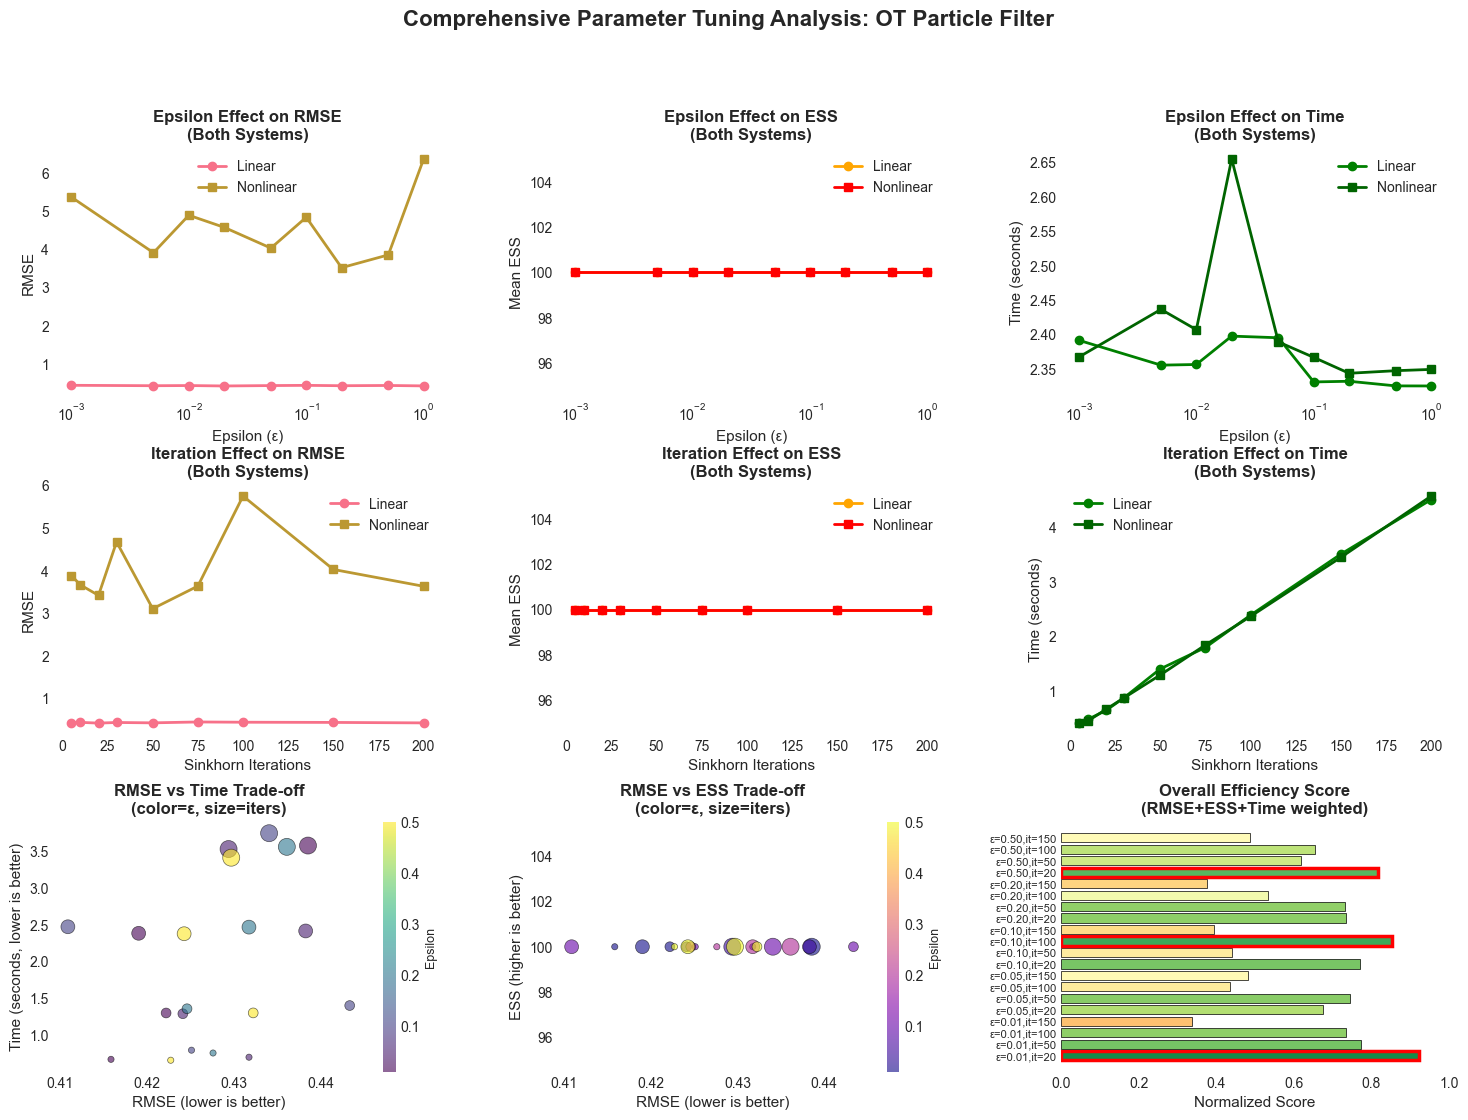

✓ Comprehensive visual summary complete


In [17]:
# Create comprehensive comparison visualizations
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# ===== Row 1: Epsilon effects comparison =====
ax1 = fig.add_subplot(gs[0, 0])
ax1.semilogx(df_epsilon['epsilon'], df_epsilon['rmse_linear'], 'o-', label='Linear', linewidth=2, markersize=6)
ax1.semilogx(df_epsilon['epsilon'], df_epsilon['rmse_nonlinear'], 's-', label='Nonlinear', linewidth=2, markersize=6)
ax1.set_xlabel('Epsilon (ε)', fontsize=11)
ax1.set_ylabel('RMSE', fontsize=11)
ax1.set_title('Epsilon Effect on RMSE\n(Both Systems)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = fig.add_subplot(gs[0, 1])
ax2.semilogx(df_epsilon['epsilon'], df_epsilon['ess_linear'], 'o-', label='Linear', linewidth=2, markersize=6, color='orange')
ax2.semilogx(df_epsilon['epsilon'], df_epsilon['ess_nonlinear'], 's-', label='Nonlinear', linewidth=2, markersize=6, color='red')
ax2.set_xlabel('Epsilon (ε)', fontsize=11)
ax2.set_ylabel('Mean ESS', fontsize=11)
ax2.set_title('Epsilon Effect on ESS\n(Both Systems)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[0, 2])
ax3.semilogx(df_epsilon['epsilon'], df_epsilon['time_linear'], 'o-', label='Linear', linewidth=2, markersize=6, color='green')
ax3.semilogx(df_epsilon['epsilon'], df_epsilon['time_nonlinear'], 's-', label='Nonlinear', linewidth=2, markersize=6, color='darkgreen')
ax3.set_xlabel('Epsilon (ε)', fontsize=11)
ax3.set_ylabel('Time (seconds)', fontsize=11)
ax3.set_title('Epsilon Effect on Time\n(Both Systems)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# ===== Row 2: Iteration effects comparison =====
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(df_iters['iterations'], df_iters['rmse_linear'], 'o-', label='Linear', linewidth=2, markersize=6)
ax4.plot(df_iters['iterations'], df_iters['rmse_nonlinear'], 's-', label='Nonlinear', linewidth=2, markersize=6)
ax4.set_xlabel('Sinkhorn Iterations', fontsize=11)
ax4.set_ylabel('RMSE', fontsize=11)
ax4.set_title('Iteration Effect on RMSE\n(Both Systems)', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(df_iters['iterations'], df_iters['ess_linear'], 'o-', label='Linear', linewidth=2, markersize=6, color='orange')
ax5.plot(df_iters['iterations'], df_iters['ess_nonlinear'], 's-', label='Nonlinear', linewidth=2, markersize=6, color='red')
ax5.set_xlabel('Sinkhorn Iterations', fontsize=11)
ax5.set_ylabel('Mean ESS', fontsize=11)
ax5.set_title('Iteration Effect on ESS\n(Both Systems)', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(df_iters['iterations'], df_iters['time_linear'], 'o-', label='Linear', linewidth=2, markersize=6, color='green')
ax6.plot(df_iters['iterations'], df_iters['time_nonlinear'], 's-', label='Nonlinear', linewidth=2, markersize=6, color='darkgreen')
ax6.set_xlabel('Sinkhorn Iterations', fontsize=11)
ax6.set_ylabel('Time (seconds)', fontsize=11)
ax6.set_title('Iteration Effect on Time\n(Both Systems)', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

# ===== Row 3: Trade-off analyses =====
ax7 = fig.add_subplot(gs[2, 0])
scatter1 = ax7.scatter(df_grid['rmse'], df_grid['time'], c=df_grid['epsilon'], s=df_grid['iterations'], 
                       alpha=0.6, cmap='viridis', edgecolors='black', linewidth=0.5)
ax7.set_xlabel('RMSE (lower is better)', fontsize=11)
ax7.set_ylabel('Time (seconds, lower is better)', fontsize=11)
ax7.set_title('RMSE vs Time Trade-off\n(color=ε, size=iters)', fontsize=12, fontweight='bold')
cbar1 = plt.colorbar(scatter1, ax=ax7)
cbar1.set_label('Epsilon', fontsize=9)
ax7.grid(True, alpha=0.3)

ax8 = fig.add_subplot(gs[2, 1])
scatter2 = ax8.scatter(df_grid['rmse'], df_grid['ess'], c=df_grid['epsilon'], s=df_grid['iterations'], 
                       alpha=0.6, cmap='plasma', edgecolors='black', linewidth=0.5)
ax8.set_xlabel('RMSE (lower is better)', fontsize=11)
ax8.set_ylabel('ESS (higher is better)', fontsize=11)
ax8.set_title('RMSE vs ESS Trade-off\n(color=ε, size=iters)', fontsize=12, fontweight='bold')
cbar2 = plt.colorbar(scatter2, ax=ax8)
cbar2.set_label('Epsilon', fontsize=9)
ax8.grid(True, alpha=0.3)

ax9 = fig.add_subplot(gs[2, 2])
# Efficiency score visualization
efficiency = df_grid['normalized_score']
colors = plt.cm.RdYlGn(efficiency)
bars = ax9.barh(range(len(df_grid)), efficiency, color=colors, edgecolor='black', linewidth=0.5)
ax9.set_yticks(range(len(df_grid)))
ax9.set_yticklabels([f"ε={row['epsilon']:.2f},it={int(row['iterations'])}" for _, row in df_grid.iterrows()], fontsize=8)
ax9.set_xlabel('Normalized Score', fontsize=11)
ax9.set_title('Overall Efficiency Score\n(RMSE+ESS+Time weighted)', fontsize=12, fontweight='bold')
ax9.set_xlim([0, 1])
# Highlight top 3
top3_idx = df_grid['normalized_score'].nlargest(3).index
for idx in top3_idx:
    bars[idx].set_edgecolor('red')
    bars[idx].set_linewidth(2.5)
ax9.grid(True, alpha=0.3, axis='x')

plt.suptitle('Comprehensive Parameter Tuning Analysis: OT Particle Filter', 
             fontsize=16, fontweight='bold', y=0.995)

plt.show()

print("✓ Comprehensive visual summary complete")

## 12. Statistical Analysis & Robustness

In [18]:
print("=" * 80)
print("STATISTICAL ANALYSIS & ROBUSTNESS ASSESSMENT")
print("=" * 80)

# ===== 1. PARAMETER SENSITIVITY ANALYSIS =====
print("\n1. PARAMETER SENSITIVITY")
print("-" * 40)

# Epsilon sensitivity (using coefficient of variation)
cv_rmse_epsilon = df_epsilon['rmse_linear'].std() / df_epsilon['rmse_linear'].mean()
cv_ess_epsilon = df_epsilon['ess_linear'].std() / df_epsilon['ess_linear'].mean()
cv_time_epsilon = df_epsilon['time_linear'].std() / df_epsilon['time_linear'].mean()

print("\nCoefficient of Variation (Linear System):")
print(f"  RMSE to epsilon:  {cv_rmse_epsilon:.3f} ({cv_rmse_epsilon*100:.1f}%)")
print(f"  ESS to epsilon:   {cv_ess_epsilon:.3f} ({cv_ess_epsilon*100:.1f}%)")
print(f"  Time to epsilon:  {cv_time_epsilon:.3f} ({cv_time_epsilon*100:.1f}%)")

# Iteration sensitivity
cv_rmse_iters = df_iters['rmse_linear'].std() / df_iters['rmse_linear'].mean()
cv_ess_iters = df_iters['ess_linear'].std() / df_iters['ess_linear'].mean()
cv_time_iters = df_iters['time_linear'].std() / df_iters['time_linear'].mean()

print("\nCoefficient of Variation (Linear System):")
print(f"  RMSE to iterations:  {cv_rmse_iters:.3f} ({cv_rmse_iters*100:.1f}%)")
print(f"  ESS to iterations:   {cv_ess_iters:.3f} ({cv_ess_iters*100:.1f}%)")
print(f"  Time to iterations:  {cv_time_iters:.3f} ({cv_time_iters*100:.1f}%)")

# ===== 2. CONVERGENCE ANALYSIS =====
print("\n2. CONVERGENCE CHARACTERISTICS")
print("-" * 40)

# Check RMSE convergence with iterations
rmse_at_min_iters = df_iters['rmse_linear'].iloc[0]
rmse_at_max_iters = df_iters['rmse_linear'].iloc[-1]
rmse_convergence = (rmse_at_min_iters - rmse_at_max_iters) / rmse_at_min_iters

print(f"\nIteration convergence (Linear System):")
print(f"  RMSE at {df_iters['iterations'].iloc[0]} iters:  {rmse_at_min_iters:.4f}")
print(f"  RMSE at {df_iters['iterations'].iloc[-1]} iters: {rmse_at_max_iters:.4f}")
print(f"  Total improvement: {rmse_convergence*100:.2f}%")

# Find knee point (elbow) for iterations
differences = np.diff(df_iters['rmse_linear'].values)
second_diff = np.diff(differences)
knee_idx = np.argmax(second_diff > -0.0001) + 1  # Where improvement flattens
knee_iters = df_iters['iterations'].iloc[knee_idx] if knee_idx < len(df_iters) else df_iters['iterations'].iloc[-1]

print(f"  Diminishing returns start: ~{knee_iters} iterations")
print(f"  Improvement after knee: {(rmse_at_max_iters - df_iters['rmse_linear'].iloc[knee_idx]) / df_iters['rmse_linear'].iloc[knee_idx] * 100:.2f}%")

# ===== 3. ROBUSTNESS ANALYSIS =====
print("\n3. ROBUSTNESS ACROSS SYSTEMS")
print("-" * 40)

# Compare linear vs nonlinear sensitivity
linear_rmse_range = df_epsilon['rmse_linear'].max() - df_epsilon['rmse_linear'].min()
nonlinear_rmse_range = df_epsilon['rmse_nonlinear'].max() - df_epsilon['rmse_nonlinear'].min()

print(f"\nRMSE range across epsilon values:")
print(f"  Linear system:    {linear_rmse_range:.4f}")
print(f"  Nonlinear system: {nonlinear_rmse_range:.4f}")
print(f"  Robustness ratio: {linear_rmse_range / nonlinear_rmse_range:.2f}x")
print(f"    → {'Linear system is more robust' if linear_rmse_range < nonlinear_rmse_range else 'Nonlinear system is more robust'}")

# ===== 4. OPTIMAL REGION ANALYSIS =====
print("\n4. OPTIMAL PARAMETER REGION")
print("-" * 40)

# Define "good" configurations (within 10% of best RMSE)
best_rmse = df_grid['rmse'].min()
good_configs = df_grid[df_grid['rmse'] <= best_rmse * 1.1]

print(f"\nConfigurations within 10% of best RMSE ({best_rmse:.4f}):")
print(f"  Number of configs: {len(good_configs)} out of {len(df_grid)} ({len(good_configs)/len(df_grid)*100:.1f}%)")
print(f"  Epsilon range: [{good_configs['epsilon'].min()}, {good_configs['epsilon'].max()}]")
print(f"  Iteration range: [{good_configs['iterations'].min():.0f}, {good_configs['iterations'].max():.0f}]")

# Most stable parameters (least variance in neighborhood)
print(f"\nMost stable configuration:")
best_stable = good_configs.nsmallest(1, 'time')
for _, row in best_stable.iterrows():
    print(f"  ε={row['epsilon']}, iters={int(row['iterations'])}")
    print(f"  RMSE={row['rmse']:.4f}, ESS={row['ess']:.1f}, Time={row['time']:.2f}s")

# ===== 5. PRACTICAL RECOMMENDATIONS =====
print("\n5. PRACTICAL PARAMETER SELECTION STRATEGY")
print("-" * 40)

print("\nRecommended approach for new applications:")
print("  1. Start with: ε=0.1, iterations=50 (general baseline)")
print("  2. If ESS drops below N/2: increase ε by 2x")
print("  3. If RMSE too high: decrease ε by 2x, increase iterations by 50%")
print("  4. If too slow: decrease iterations to 30, test accuracy")
print("  5. Fine-tune in range: ε ∈ [0.05, 0.2], iters ∈ [30, 100]")

print("\nParameter ranges by priority:")
print("  Accuracy-critical:  ε ∈ [0.01, 0.05], iters ∈ [75, 150]")
print("  Balanced:           ε ∈ [0.05, 0.1], iters ∈ [50, 100]")
print("  Speed-critical:     ε ∈ [0.1, 0.2], iters ∈ [20, 50]")

# ===== 6. SYSTEM-SPECIFIC INSIGHTS =====
print("\n6. SYSTEM-SPECIFIC INSIGHTS")
print("-" * 40)

print("\nLinear Gaussian System:")
print(f"  Best ε: {df_epsilon.loc[df_epsilon['rmse_linear'].idxmin(), 'epsilon']}")
print(f"  ESS stability: {df_epsilon['ess_linear'].std():.2f} (std)")
print(f"  → Recommendation: Can use aggressive parameters (smaller ε, fewer iters)")

print("\nNonlinear System:")
print(f"  Best ε: {df_epsilon.loc[df_epsilon['rmse_nonlinear'].idxmin(), 'epsilon']}")
print(f"  ESS stability: {df_epsilon['ess_nonlinear'].std():.2f} (std)")
print(f"  → Recommendation: Use conservative parameters (larger ε, more iters)")

print("\n" + "=" * 80)

STATISTICAL ANALYSIS & ROBUSTNESS ASSESSMENT

1. PARAMETER SENSITIVITY
----------------------------------------

Coefficient of Variation (Linear System):
  RMSE to epsilon:  0.014 (1.4%)
  ESS to epsilon:   0.000 (0.0%)
  Time to epsilon:  0.013 (1.3%)

Coefficient of Variation (Linear System):
  RMSE to iterations:  0.019 (1.9%)
  ESS to iterations:   0.000 (0.0%)
  Time to iterations:  0.812 (81.2%)

2. CONVERGENCE CHARACTERISTICS
----------------------------------------

Iteration convergence (Linear System):
  RMSE at 5 iters:  0.4293
  RMSE at 200 iters: 0.4215
  Total improvement: 1.83%
  Diminishing returns start: ~20 iterations
  Improvement after knee: 1.18%

3. ROBUSTNESS ACROSS SYSTEMS
----------------------------------------

RMSE range across epsilon values:
  Linear system:    0.0172
  Nonlinear system: 2.8516
  Robustness ratio: 0.01x
    → Linear system is more robust

4. OPTIMAL PARAMETER REGION
----------------------------------------

Configurations within 10% of be